In [2]:
# Step 1: Setup and Dataset Preparation

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Step 2: Download and Extract EuroSAT Dataset
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip -q EuroSAT.zip -d EuroSAT
!rm EuroSAT.zip

--2025-03-26 05:37:51--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M   117MB/s    in 0.8s    

2025-03-26 05:37:52 (117 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [5]:

# Step 3: Create DataFrame with labels
def create_dataframe(data_dir):
    urban_classes = ['Highway', 'Industrial', 'Residential']
    data = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            label = 1 if class_name in urban_classes else 0
            for img_file in os.listdir(class_dir):
                data.append({
                    'filepath': os.path.join(class_dir, img_file),
                    'label': label
                })
    return pd.DataFrame(data)

data_dir = 'EuroSAT/2750'
df = create_dataframe(data_dir)
(data_dir)

'EuroSAT/2750'

In [6]:
# Step 4: Split dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['label'], random_state=42)

In [7]:
# Step 5: Data Augmentation and Preprocessing
IMG_SIZE = 64
BATCH_SIZE = 32

def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def create_dataset(df, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'], df['label']))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y),
                            num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)


In [9]:
# Step 6: Build Model
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 2, 2, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# Step 7: Train Model
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.9518 - auc_1: 0.9875 - loss: 0.1263 - val_accuracy: 0.9589 - val_auc_1: 0.9938 - val_loss: 0.0997
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9501 - auc_1: 0.9876 - loss: 0.1276 - val_accuracy: 0.9722 - val_auc_1: 0.9947 - val_loss: 0.0790
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.9500 - auc_1: 0.9881 - loss: 0.1234 - val_accuracy: 0.9752 - val_auc_1: 0.9954 - val_loss: 0.0744
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - accuracy: 0.9532 - auc_1: 0.9895 - loss: 0.1178 - val_accuracy: 0.9715 - val_auc_1: 0.9952 - val_loss: 0.0758
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.9564 - auc_1: 0.9900 - loss: 0.1102 - val_accuracy: 0.9741 - val_auc_1: 0.9940 - val_loss: 0.0754
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.9617 - auc_1: 0.9920 - loss: 0.1013 - val_accuracy: 0.9759 - val_auc_1: 0.9950 - val_loss: 0.0728
Epoc

In [12]:
# Step 8: Evaluate Model
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9716 - auc_1: 0.9945 - loss: 0.0829
Test Accuracy: 0.9696
Test AUC: 0.9936


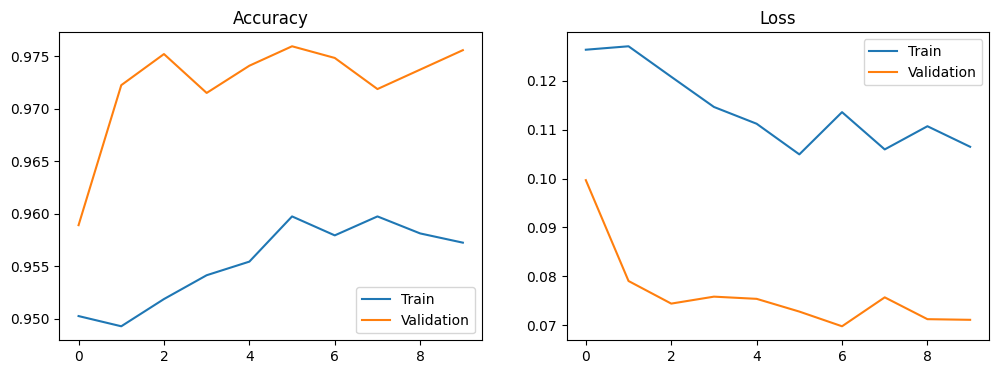

In [13]:

# Step 9: Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [14]:
# Step 10: Detailed Evaluation and Visualization
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, ConfusionMatrixDisplay)


In [15]:
# Generate predictions
print("Generating predictions...")
true_labels = []
probabilities = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    probabilities.extend(preds.flatten())
    true_labels.extend(labels.numpy())

predicted_labels = np.round(probabilities).astype(int)
true_labels = np.array(true_labels).astype(int)


Generating predictions...


<Figure size 800x600 with 0 Axes>

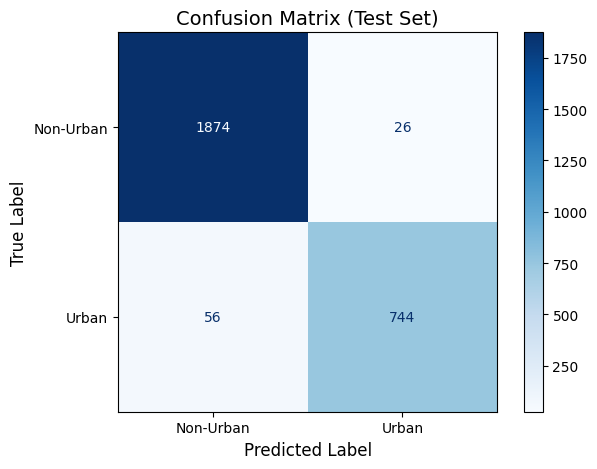

In [16]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non-Urban', 'Urban'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels,
                            target_names=['Non-Urban', 'Urban'],
                            digits=4))


Classification Report:
              precision    recall  f1-score   support

   Non-Urban     0.9710    0.9863    0.9786      1900
       Urban     0.9662    0.9300    0.9478       800

    accuracy                         0.9696      2700
   macro avg     0.9686    0.9582    0.9632      2700
weighted avg     0.9696    0.9696    0.9695      2700



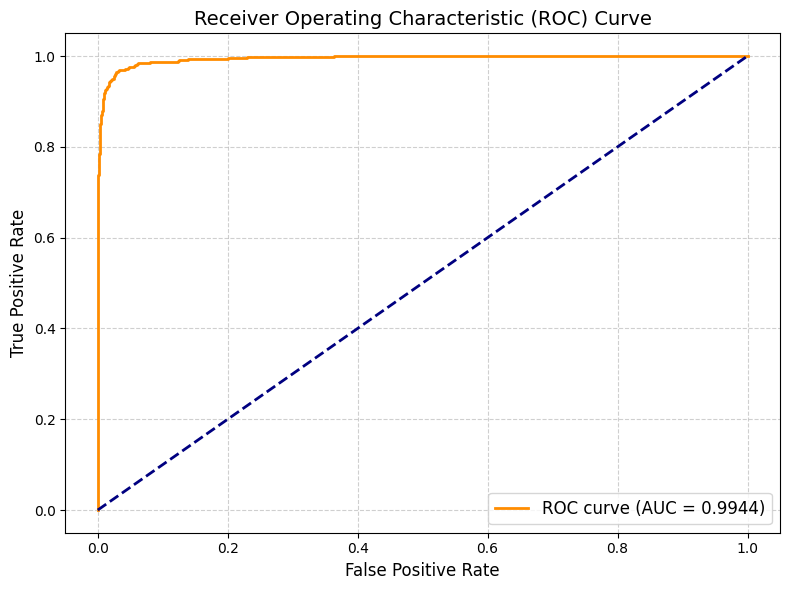

In [18]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

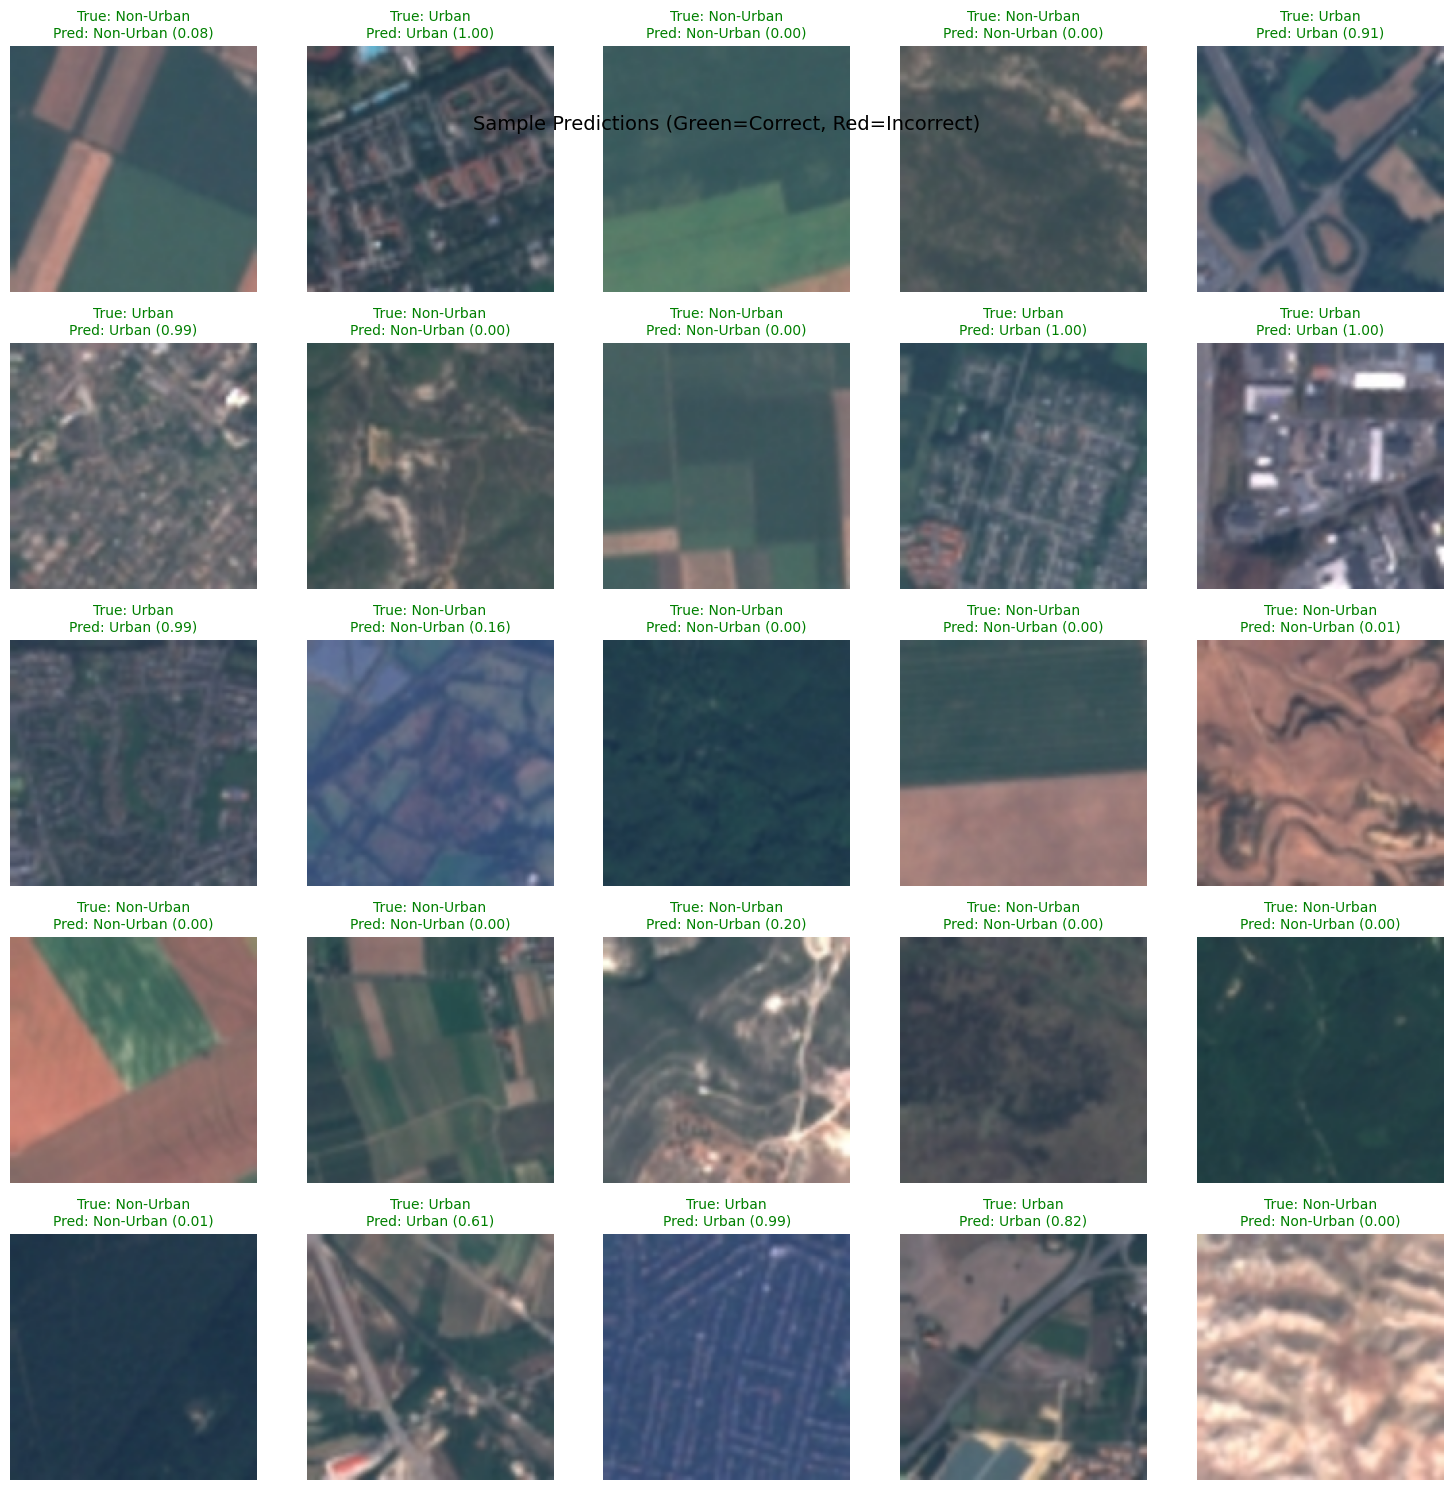

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#Get sample images from test set
sample_df = test_df.sample(n=25, random_state=42)
plt.figure(figsize=(15, 15))

#  Create visualization function
def show_predictions(model, sample_df, img_size=128):
    for i, row in enumerate(sample_df.itertuples()):
        # Load and prepare image for display
        img = tf.io.read_file(row.filepath)
        img_disp = tf.image.decode_jpeg(img, channels=3)
        img_disp = tf.image.resize(img_disp, [img_size, img_size])
        img_disp = img_disp.numpy().astype('uint8')

        # Preprocess for model prediction
        img_model = tf.image.resize(img_disp, [IMG_SIZE, IMG_SIZE])
        img_model = tf.keras.applications.efficientnet.preprocess_input(img_model)
        img_model = tf.expand_dims(img_model, 0)  # Add batch dimension

        # Get prediction
        pred = model.predict(img_model, verbose=0)[0][0]
        pred_label = "Urban" if pred > 0.5 else "Non-Urban"
        true_label = "Urban" if row.label == 1 else "Non-Urban"
        correct = pred_label == true_label

        # Create subplot
        plt.subplot(5, 5, i+1)
        plt.imshow(img_disp)
        plt.axis('off')

        # Customize title
        title_color = 'green' if correct else 'red'
        title = f"True: {true_label}\nPred: {pred_label} ({pred:.2f})"
        plt.title(title, color=title_color, fontsize=10)

    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', y=0.92, fontsize=14)
    plt.show()

#  Generate visualization
show_predictions(model, sample_df)